In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
import csv
from ast import literal_eval
import typing as tp

sys.path.append("..")

MAX_UINT8 = 255


In [2]:
from src.dataset import Dataset

In [3]:
ann_path = "/home/fatuus/data/goods-barcodes/annotation.tsv"
images_dir = "/home/fatuus/data/goods-barcodes/images"

dataset = Dataset(
    ann_path=ann_path, 
    images_path=images_dir
)

In [34]:
import pandas as pd

def split_3way(
    ann_path, 
    target_dir,
    train_prop=0.8, 
    val_prop=0.1,
):
    d_full = pd.read_csv(ann_path, delimiter="\t")
    splits = (
        int(train_prop * d_full.shape[0]),
        int((train_prop+val_prop) * d_full.shape[0])
    )
    i_train, i_val, i_test = np.split(
        list(d_full.index), splits
    )
    for name, ids in [
        ("train", i_train),
        ("val", i_val),
        ("test", i_test),
    ]:
        df = d_full.loc[ids]
        df.to_csv(
            os.path.join(target_dir, f"{name}.tsv"),
            sep="\t",
            index=None,
            header=True
        )

In [35]:
split_3way(
    ann_path, 
    "./",
    train_prop=0.8, 
    val_prop=0.1,
)

In [117]:
def read_annotation(path: str):
    result = []
    with open(ann_path, newline='') as fp:
        reader = csv.DictReader(fp, delimiter="\t")
        for row in reader:
            row["p1"] = literal_eval(row["p1"])
            row["p2"] = literal_eval(row["p2"])
            result.append(row)
    return result

def read_image(
    image_path: str,
    means=(0.485, 0.456, 0.406),
    stds=(0.229, 0.224, 0.225)
):
    """
    :param image_path: path to the image
    :param means: mean values for colors in ImageNet
    :param stds: standard deviations for colors in ImageNet
    """
    # 1. reading file to np.ndarray with shape=(H,W,C)
    image = cv2.imread(image_path)
    # 2.  BGR -> RGB(OpenCV->common)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 6. scaling into interval [0,1]
    img = cv2.resize(image, target_image_size) / MAX_UINT8
    # 7. [H,W,C] -> [C,H,W] (common->torch-ish)
    img = np.transpose(img,  (2, 0, 1))
    # 8. Вычитаем из каждого цвета числа поэлементно (это средние на всем train?)
    img -= np.array(means)[:, None, None]
    # 9. Делим каждый цвет на числа поэлементно (это std по всему train?)
    img /= np.array(stds)[:, None, None]
    return img


In [122]:
class Dataset:
    def __init__(self, ann_path, images_path):
        self.ann_path = ann_path
        self.images_path = images_path
        self.ann = read_annotation(ann_path)

    def __getitem__(self, idx: int):
        image = read_image(
            os.path.join(
                self.images_path,
                self.ann[idx]["filename"]
            )
        )
        return {
            "image": image,
            "label": (*self.ann[idx]["p1"], *self.ann[idx]["p2"]),
            "ocr": self.ann[idx]["code"],
        }
        
    def __len__(self) -> int:
        return len(self.ann)


In [126]:
ann_path = "/home/fatuus/data/goods-barcodes/annotation.tsv"
images_dir = "/home/fatuus/data/goods-barcodes/images"

dataset = Dataset(ann_path, images_dir)

In [108]:
annotations = read_annotation(ann_path)

In [109]:
annotations

[{'filename': 'c234c76c-d72d-4d60-8066-e99f62361c1c--ru.a6a77966-14c1-49d8-bdd3-c9cbf12ae35d.jpg',
  'code': '4810153026194',
  'p1': (542, 210),
  'p2': (685, 489)},
 {'filename': '0b56af7e-386c-410a-8f46-74350f755d77--ru.4c7208d1-cba4-4539-967d-1c87ad0f6d2e.jpg',
  'code': '8714100708408',
  'p1': (474, 216),
  'p2': (782, 625)},
 {'filename': '77c7bd8d-bb64-4c4b-94c5-798a903eaa4d--ru.12f5929c-9d0e-49e5-9300-4aa2bd63bc51.jpg',
  'code': '4820240030508',
  'p1': (657, 173),
  'p2': (950, 762)},
 {'filename': '5d60b81b-e31d-4530-bed1-27a8872d1f02--ru.53fed99f-fe97-435b-a4d4-57f1ed6d9f21.jpg',
  'code': '4607001770350',
  'p1': (665, 66),
  'p2': (841, 615)},
 {'filename': 'bb225480-a447-4232-85ab-ce22f1dec070--ru.09dd5220-73bc-4ca1-b42e-b6003ee8b311.jpg',
  'code': '4605035006964',
  'p1': (592, 269),
  'p2': (839, 717)},
 {'filename': '6e042372-20ec-4a26-8340-3653cf0c681d--ru.407738ff-e321-4f6c-8a9d-d9c146d3d801.jpg',
  'code': '4690363095759',
  'p1': (849, 23),
  'p2': (974, 253)},


In [113]:
def read_image(
    image_path: str,
    means=(0.485, 0.456, 0.406),
    stds=(0.229, 0.224, 0.225)
):
    # 1. reading file to np.ndarray with shape=(H,W,C)
    image = cv2.imread(image_path)
    # 2.  BGR -> RGB(OpenCV->common)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 6. scaling into interval [0,1]
    img = cv2.resize(image, target_image_size) / MAX_UINT8
    # 7. [H,W,C] -> [C,H,W] (common->torch-ish)
    img = np.transpose(img,  (2, 0, 1))
    # 8. Вычитаем из каждого цвета числа поэлементно (это средние на всем train?)
    img -= np.array(means)[:, None, None]
    # 9. Делим каждый цвет на числа поэлементно (это std по всему train?)
    img /= np.array(stds)[:, None, None]
    return img

In [36]:
path = "../data/mini_01/20201211_100_rgb.png"
# read_image(image_path=path)

In [62]:
# 1. Считываем файл, получаем np.ndarray с размерностью [H,W,C]
image = cv2.imread(path)

# 2. Меняем порядок записи цветов с BGR на RGB (с OpenCV-шного на общепринятый)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 6. Шкалируем данные в диапазон [0,1]
img = cv2.resize(image, target_image_size) / MAX_UINT8

# 7. Меняем порядок осей с [H,W,C] на [C, H, W] (с общепринятого на torch-овый)
img = np.transpose(img,  (2, 0, 1))

# 8. Вычитаем из каждого цвета числа поэлементно (это средние на всем train?)
img -= np.array([0.485, 0.456, 0.406])[:, None, None]

# 9. Делим каждый цвет на числа поэлементно (это std по всему train?)
img /= np.array([0.229, 0.224, 0.225])[:, None, None]

In [72]:
H, W, _ = image.shape


In [73]:
H,W

(1333, 1000)

In [79]:
x0,y0,x1,y1 = 542, 210, 685, 489
# 0 0.528906 0.614865 0.940625 0.767568

coords=[(210, 542), (210, 685), (489, 685), (489, 542), (210, 542)]


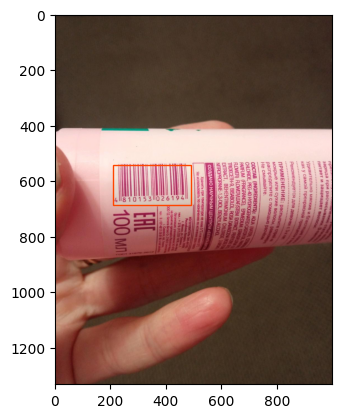

In [98]:
def draw_record(images_path, record):
    p1 = literal_eval(record["p1"])
    p2 = literal_eval(record["p2"])
    y = [p1[0], p2[0]]
    x = [p1[1], p2[1]]
    coords = [
        (min(x), min(y)),
        (min(x), max(y)),
        (max(x), max(y)),
        (max(x), min(y)),
        (min(x), min(y))
    ]
    print(f"{coords=}")
    poly = Polygon(coords, fc='none', ec='orangered')
    plt.imshow(image)
    plt.gca().add_patch(poly)

draw_record(images_dir, row)

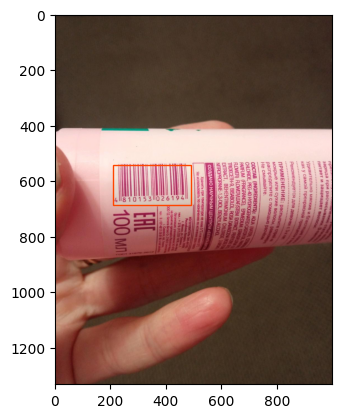

In [99]:
y = [x0, x1]
x = [y0, y1]

coords = [(min(x), min(y)),(min(x), max(y)), (max(x), max(y)), (max(x), min(y)), (min(x), min(y))]

poly = Polygon(coords, fc='none', ec='orangered')

plt.imshow(image)
plt.gca().add_patch(poly)

In [69]:
x0

542